### Energy Analysis Notebook
#### Micro Renewable Energy System - Generation, Tariffs, Export & Battery Optimisation

This notebook analyses **30 minute smart meter electricity data** to compare:
- Electricity tariffs
- Grid export vs battery storage strategies
- EV night charging
- Household usage behaviour

The goal is to determine the **most cost effective energy management strategy** for a modern home using:
- Solar PV
- Smart metering
- Time of use tariffs
- EV charging
- Battery storage


---

### Objectives

- Analyse real and synthetic **30 minute electricity consumption data**
- Compare multiple **tariff structures**

- Evaluate the financial impact of:
    - Exporting to the grid
    - Storing energy in a battery

- Compare two household profiles:
    - All day occupancy
    - Away 9am to 5pm with EV charging

- Determine:
    - Annual electricity cost
    - Export revenue
    - Battery payback period
    - ROI (Return on Investment)

    ---

### Case Study Definitions

#### Case Study 1 - All Day Occupancy
This study uses real household electricity consumption data from a home that is occupied all day. The household has a solar PV system installed on the roof, generating electricity during daylight hours. This scenario represents a high daytime demand profile, where most solar generation is self-consumed, resulting in limited surplus energy for export to the grid.

- High electricity usage throughout the day
- High solar self consumption


#### Case Study 2 - Away 9am to 5pm with EV Charging
The purpose of this synthetic case study is to create a realistic scenario where solar PV generation occurs during periods of low household demand. This increases surplus energy available either for export to the grid or for storage in a home battery. It allows a clear comparison between the two strategies while keeping the solar PV system constant and varying only household behaviour.

- Low daytime usage
- High evening peak (5:30pm to 7:30pm)
- Overnight EV charging
- High solar generation during working hours

---

### Import Required Libraries

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure pandas to display all columns in DataFrames
pd.set_option("display.max_columns", None)

### Load the Datasets

In [127]:

import pandas as pd

%pip install openpyxl

import os

# Define file paths for the datasets
file_case1 = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Data Set 1 - All Day Usage - 30 Min Interval Data.xlsx"  
file_case2 = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Data Set 2 - 9am to 5pm Low Usage - 30 Min Interval Data.xlsx"  

# Check if the files exist
if not os.path.exists(file_case1):
	raise FileNotFoundError(f"File not found: {file_case1}. Please provide the correct path.")
if not os.path.exists(file_case2):
	raise FileNotFoundError(f"File not found: {file_case2}. Please provide the correct path.")

# Load the All Day Occupancy dataset
df_case1 = pd.read_excel(file_case1, engine='openpyxl')     

# Load the Low Daytime Usage with EV dataset
df_case2 = pd.read_excel(file_case2, engine='openpyxl')     

# Show previews of both datasets
df_case1.head(), df_case2.head()


Note: you may need to restart the kernel to use updated packages.


(        Date  00:00:00  00:30:00  01:00:00  01:30:00  02:00:00  02:30:00  \
 0 2024-11-28     0.526     0.469     0.477     0.676     0.972     0.885   
 1 2024-11-29     0.437     0.448     0.483     0.492     0.473     0.487   
 2 2024-11-30     0.563     0.552     0.534     0.486     0.517     0.531   
 3 2024-12-01     0.549     0.521     0.462     0.475     0.476     0.491   
 4 2024-12-02     0.594     0.522     0.497     0.448     0.525     0.507   
 
    03:00:00  03:30:00  04:00:00  04:30:00  05:00:00  05:30:00  06:00:00  \
 0     0.893     0.732     0.476     0.479     0.599     0.583     0.621   
 1     0.483     0.486     0.484     0.955     0.781     0.741     1.375   
 2     0.532     0.545     0.536     0.532     0.550     0.522     0.532   
 3     0.452     0.415     0.474     0.475     0.595     0.603     0.877   
 4     0.516     0.502     0.465     0.508     0.634     0.726     1.656   
 
    06:30:00  07:00:00  07:30:00  08:00:00  08:30:00  09:00:00  09:30:00  \
 0

### Data Validation 

In [128]:
# Examine the structure and validity of both datasets

print("CASE STUDY 1 - STRUCTURE SUMMARY\n")
df_case1.info()    # Displays column names, data types, and non null counts 
print("\n----------------------------------------\n")

print("CASE STUDY 2 - STRUCTURE SUMMARY\n")
df_case2.info()    
print("\n----------------------------------------\n")


print("COLUMN NAMES IN CASE STUDY 1:\n")
print(df_case1.columns.tolist())     # Print ordered list of all column names

print("\nCOLUMN NAMES IN CASE STUDY 2:\n")
print(df_case2.columns.tolist())
print("\n----------------------------------------\n")



# Identify all columns except the Date column
interval_columns_case1 = df_case1.columns[1:]    # Assumes column 0 is 'Date'
interval_columns_case2 = df_case2.columns[1:]

print(f"Case Study 1 interval column count: {len(interval_columns_case1)}")  # Should be 48
print(f"Case Study 2 interval column count: {len(interval_columns_case2)}\n")

# Validate expected number of intervals
if len(interval_columns_case1) == 48:
    print("✔ Case Study 1 contains the correct number of 30 minute interval columns.\n")
else:
    print("Case Study 1 does NOT contain 48 interval columns. Please check dataset formatting.\n")

if len(interval_columns_case2) == 48:
    print("✔ Case Study 2 contains the correct number of 30 minute interval columns.\n")
else:
    print("Case Study 2 does NOT contain 48 interval columns. Please check dataset formatting.\n")



print("Checking for missing values in Case Study 1...\n")
print(df_case1.isna().sum())    # Counts missing values in each column

print("\nChecking for missing values in Case Study 2...\n")
print(df_case2.isna().sum())
print("\n----------------------------------------\n")




# Convert to numeric and report errors if found
case1_non_numeric = df_case1[interval_columns_case1].apply(lambda col: pd.to_numeric(col, errors="coerce")).isna().sum().sum()
case2_non_numeric = df_case2[interval_columns_case2].apply(lambda col: pd.to_numeric(col, errors="coerce")).isna().sum().sum()

print(f"Case Study 1 non-numeric entries in interval columns: {case1_non_numeric}")
print(f"Case Study 2 non-numeric entries in interval columns: {case2_non_numeric}\n")

if case1_non_numeric == 0 and case2_non_numeric == 0:
    print("✔ All interval columns contain valid numeric data.\n")
else:
    print("One or more interval columns contain invalid (non-numeric) values.\n")




# Attempt to convert Date column to datetime format
df_case1['Date'] = pd.to_datetime(df_case1['Date'], errors='coerce')
df_case2['Date'] = pd.to_datetime(df_case2['Date'], errors='coerce')

print("Date conversion complete.\n")

# Check for date conversion failures (NaT values)
case1_bad_dates = df_case1['Date'].isna().sum()
case2_bad_dates = df_case2['Date'].isna().sum()

print(f"Case Study 1 invalid dates: {case1_bad_dates}")
print(f"Case Study 2 invalid dates: {case2_bad_dates}\n")

# Check that dates are continuous (no missing days)
case1_date_range = df_case1['Date'].max() - df_case1['Date'].min()
case2_date_range = df_case2['Date'].max() - df_case2['Date'].min()

print(f"Case Study 1 date span: {case1_date_range}")
print(f"Case Study 2 date span: {case2_date_range}\n")

print("✔ Dataset validation complete.\n")


CASE STUDY 1 - STRUCTURE SUMMARY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 49 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      364 non-null    datetime64[ns]
 1   00:00:00  364 non-null    float64       
 2   00:30:00  364 non-null    float64       
 3   01:00:00  363 non-null    float64       
 4   01:30:00  363 non-null    float64       
 5   02:00:00  364 non-null    float64       
 6   02:30:00  364 non-null    float64       
 7   03:00:00  364 non-null    float64       
 8   03:30:00  364 non-null    float64       
 9   04:00:00  364 non-null    float64       
 10  04:30:00  364 non-null    float64       
 11  05:00:00  364 non-null    float64       
 12  05:30:00  364 non-null    float64       
 13  06:00:00  364 non-null    float64       
 14  06:30:00  364 non-null    float64       
 15  07:00:00  364 non-null    float64       
 16  07:30:00  364 non-null    fl

### Data Cleaning

In [129]:
# Clean both datasets by removing invalid rows, and converting data types


df_case1 = df_case1.dropna(subset=['Date'])    # Ensure every row has a valid date

df_case2 = df_case2.dropna(subset=['Date'])    # Ensure every row has a valid date


# All columns except the first ('Date') are interval readings
interval_cols_case1 = df_case1.columns[1:]     # Select all 30 minute interval columns for Case Study 1
interval_cols_case2 = df_case2.columns[1:]     # Select all 30 minute interval columns for Case Study 2



# Convert text values to numeric and replace conversion errors with NaN (which we will fill later)
df_case1[interval_cols_case1] = df_case1[interval_cols_case1].apply(
    lambda col: pd.to_numeric(col, errors='coerce')   # Converts strings to floats
)

df_case2[interval_cols_case2] = df_case2[interval_cols_case2].apply(
    lambda col: pd.to_numeric(col, errors='coerce')   # Same conversion for Case Study 2
)


# Replace missing reading with 0 kWh
df_case1[interval_cols_case1] = df_case1[interval_cols_case1].fillna(0)   
df_case2[interval_cols_case2] = df_case2[interval_cols_case2].fillna(0)   



# Sorting ensures the time series is in chronological order
df_case1 = df_case1.sort_values(by='Date')     
df_case2 = df_case2.sort_values(by='Date')    



# Resetting gives clean, sequential indexing starting from 0
df_case1 = df_case1.reset_index(drop=True)     
df_case2 = df_case2.reset_index(drop=True)     


# Print cleaning summary
print("CLEANING COMPLETE\n")

print("Case Study 1 Shape (rows, columns):", df_case1.shape)   
print("Case Study 2 Shape (rows, columns):", df_case2.shape)   

print("\nFirst dates after cleaning:")
print("Case Study 1 starts:", df_case1['Date'].min())         
print("Case Study 2 starts:", df_case2['Date'].min())

print("\nLast dates after cleaning:")
print("Case Study 1 ends:", df_case1['Date'].max())           
print("Case Study 2 ends:", df_case2['Date'].max())

print("\nMissing values remaining in Case Study 1:", df_case1.isna().sum().sum())   
print("Missing values remaining in Case Study 2:", df_case2.isna().sum().sum())


CLEANING COMPLETE

Case Study 1 Shape (rows, columns): (364, 49)
Case Study 2 Shape (rows, columns): (364, 49)

First dates after cleaning:
Case Study 1 starts: 2024-11-28 00:00:00
Case Study 2 starts: 2024-11-28 00:00:00

Last dates after cleaning:
Case Study 1 ends: 2025-11-26 00:00:00
Case Study 2 ends: 2025-11-26 00:00:00

Missing values remaining in Case Study 1: 0
Missing values remaining in Case Study 2: 0


### Daily Grid Energy Usage Profiles

Case Study 1 Daily Usage Summary:

count    364.000000
mean      28.896113
std       11.343073
min        7.900000
25%       19.952250
50%       26.937000
75%       37.325500
max      101.436000
Name: Daily_kWh, dtype: float64

Case Study 2 Daily Usage Summary:

count    364.000000
mean      22.938212
std        5.357470
min       10.071384
25%       19.027592
50%       22.962210
75%       26.629841
max       56.873208
Name: Daily_kWh, dtype: float64


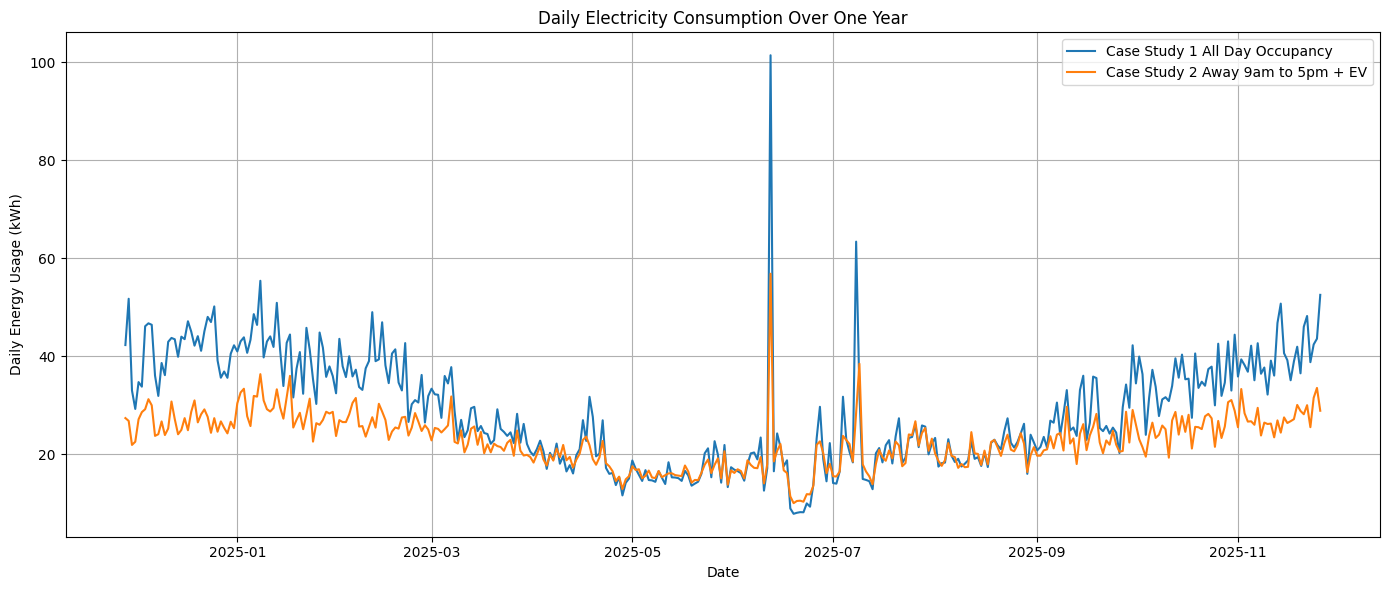

In [130]:
# Compute daily electricity consumption totals for both case studies and visualise their daily energy usage across the year.


# Sum all 48 half hour interval columns for case study 1
df_case1['Daily_kWh'] = df_case1[interval_cols_case1].sum(axis=1)    

# Sum all intervals for case study 2
df_case2['Daily_kWh'] = df_case2[interval_cols_case2].sum(axis=1)    



# Calculate daily totals
print("Case Study 1 Daily Usage Summary:\n")
print(df_case1['Daily_kWh'].describe())    # Shows mean, min, max, std for Case Study 1

print("\nCase Study 2 Daily Usage Summary:\n")
print(df_case2['Daily_kWh'].describe())    # Summary for Case Study 2



# Plot daily energy usage for both datasets
plt.figure(figsize=(14, 6))  # Set plot size

plt.plot(df_case1['Date'], df_case1['Daily_kWh'], label='Case Study 1 All Day Occupancy')    # Daily usage line plot for Case Study 1
plt.plot(df_case2['Date'], df_case2['Daily_kWh'], label='Case Study 2 Away 9am to 5pm + EV') # Daily usage plot for Case Study 2

plt.xlabel("Date")                          # Label for x axis
plt.ylabel("Daily Energy Usage (kWh)")       # Label for y axis
plt.title("Daily Electricity Consumption Over One Year")     # Plot title
plt.legend()                                 # Show legend to distinguish the two case studies
plt.grid(True)                               # Add grid lines for readability

plt.tight_layout()                            # Reduce whitespace and fit plot neatly
plt.show()                                    # Display the plot


### Monthly Grid Energy Totals

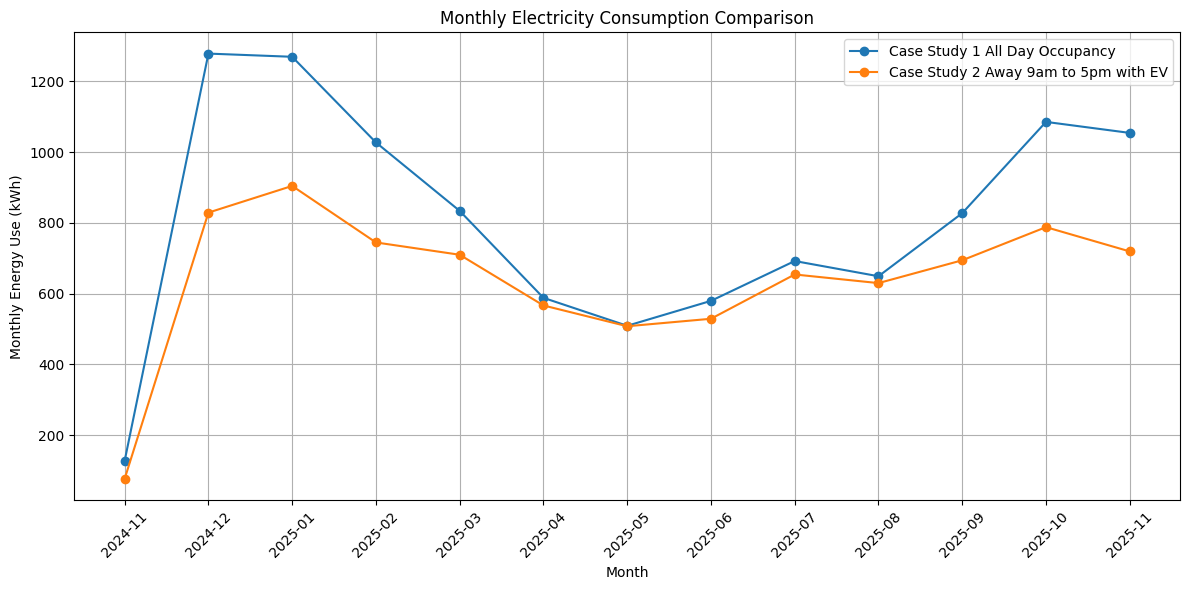

In [131]:
# Monthly electricity consumption totals for both case studies

import matplotlib.pyplot as plt    

# Group by month and calculate total kWh for Case Study 1
monthly_case1 = (
    df_case1.groupby(df_case1['Date'].dt.to_period('M'))['Daily_kWh']
    .sum()
    .reset_index()
    .rename(columns={'Date': 'Month', 'Daily_kWh': 'Total_kWh'})
)

# Group by month and calculate total kWh for Case Study 2
monthly_case2 = (
    df_case2.groupby(df_case2['Date'].dt.to_period('M'))['Daily_kWh']
    .sum()
    .reset_index()
    .rename(columns={'Date': 'Month', 'Daily_kWh': 'Total_kWh'})
)

# Convert Month period to string for plotting on the x axis
monthly_case1['Month'] = monthly_case1['Month'].astype(str)   # Convert period to string for Case Study 1
monthly_case2['Month'] = monthly_case2['Month'].astype(str)   # Convert period to string for Case Study 2

# Create a new figure for the plot
plt.figure(figsize=(12, 6))    # Set figure size for readability

# Plot monthly totals for Case Study 1
plt.plot(
    monthly_case1['Month'],            # X axis showing month
    monthly_case1['Total_kWh'],         # Y axis showing total monthly kWh
    marker='o',                         # Add markers for clarity
    label='Case Study 1 All Day Occupancy'   # Label for legend
)

# Plot monthly totals for Case Study 2
plt.plot(
    monthly_case2['Month'],             # X axis showing month
    monthly_case2['Total_kWh'],          # Y axis showing total monthly kWh
    marker='o',                          # Add markers for clarity
    label='Case Study 2 Away 9am to 5pm with EV'   # Label for legend
)

# Set axis labels
plt.xlabel("Month")                     # Label x axis
plt.ylabel("Monthly Energy Use (kWh)")  # Label y axis

# Set plot title
plt.title("Monthly Electricity Consumption Comparison")   # Descriptive plot title

# Rotate x axis labels for better readability
plt.xticks(rotation=45)                 # Rotate month labels

# Add grid for easier visual comparison
plt.grid(True)                           # Enable grid lines

# Display legend
plt.legend()                             # Show legend

# Adjust layout to prevent label clipping
plt.tight_layout()                      # Adjust spacing

# Display the plot
plt.show()                               # Render the plot


### Annual Grid Energy Consumption Totals

Annual Electricity Consumption Totals
Case Study 1 All Day Occupancy: 10518.18 kWh
Case Study 2 Away 9am to 5pm with EV: 8349.51 kWh


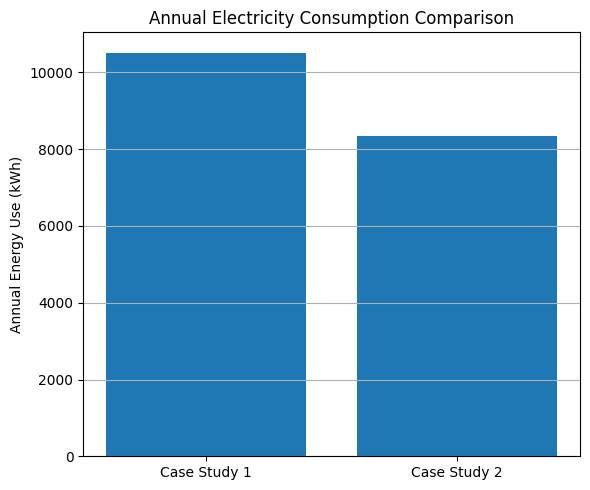

In [132]:
# Annual electricity consumption totals for both case studies

import matplotlib.pyplot as plt    # Import matplotlib for plotting

# Calculate total annual electricity consumption for Case Study 1
annual_kwh_case1 = df_case1['Daily_kWh'].sum()    # Sum all daily kWh values for the year

# Calculate total annual electricity consumption for Case Study 2
annual_kwh_case2 = df_case2['Daily_kWh'].sum()    # Sum all daily kWh values for the year

# Print annual totals for verification
print("Annual Electricity Consumption Totals")
print(f"Case Study 1 All Day Occupancy: {annual_kwh_case1:.2f} kWh")
print(f"Case Study 2 Away 9am to 5pm with EV: {annual_kwh_case2:.2f} kWh")

# Prepare data for bar chart
case_labels = ['Case Study 1', 'Case Study 2']          # Labels for the two case studies
annual_values = [annual_kwh_case1, annual_kwh_case2]   # Corresponding annual totals

# Create bar chart to compare annual consumption
plt.figure(figsize=(6, 5))                              # Set figure size
plt.bar(case_labels, annual_values)                     # Plot bar chart

# Label axes and add title
plt.ylabel("Annual Energy Use (kWh)")                   # Y axis label
plt.title("Annual Electricity Consumption Comparison")  # Plot title

# Add grid for readability
plt.grid(axis='y')                                      # Show horizontal grid lines

# Display plot
plt.tight_layout()                                      # Adjust layout
plt.show()                                              # Render plot


### Annual Solar PV Energy Generation Totals

Solar PV annual summary
Total PV generation (kWh): 8651.8
Total PV export (kWh): 4489.0
Total PV self consumed (kWh): 4162.8


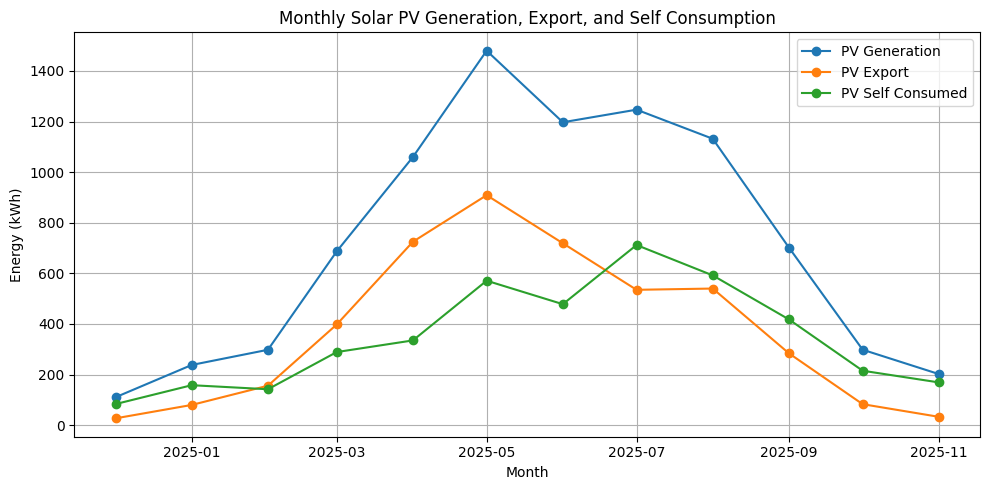

In [133]:

import pandas as pd
import matplotlib.pyplot as plt

# Define file path to the Solis Cloud PV data
pv_file_path = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Solis Cloud Data Logger - 2025..xlsx"

# Read the Excel file
# Read the Excel file, skipping the first row (header row)
df_pv = pd.read_excel(pv_file_path, skiprows=1, names=['Unnamed', 'Date', 'PV_Generation_kWh', 'PV_Export_kWh'])

# Drop rows with missing or invalid data in the Date column
df_pv = df_pv.dropna(subset=['Date'])

# Convert the Date column to datetime format, assuming the format is "MM/YYYY"
df_pv['Date'] = pd.to_datetime(df_pv['Date'], format='%m/%Y', errors='coerce')

# Drop rows where the Date conversion failed
df_pv = df_pv.dropna(subset=['Date'])

# Ensure PV_Generation_kWh and PV_Export_kWh columns are numeric
df_pv['PV_Generation_kWh'] = pd.to_numeric(df_pv['PV_Generation_kWh'], errors='coerce')
df_pv['PV_Export_kWh'] = pd.to_numeric(df_pv['PV_Export_kWh'], errors='coerce')

# Calculate monthly self consumed PV energy
df_pv['PV_Self_Consumed_kWh'] = (
    df_pv['PV_Generation_kWh'] - df_pv['PV_Export_kWh']
)

# Calculate annual totals
total_pv_generation = df_pv['PV_Generation_kWh'].sum()      # Total PV generation
total_pv_export = df_pv['PV_Export_kWh'].sum()              # Total PV export
total_pv_self_consumed = df_pv['PV_Self_Consumed_kWh'].sum()# Total PV self consumption

# Print annual PV summary
print("Solar PV annual summary")
print(f"Total PV generation (kWh): {total_pv_generation:.1f}")
print(f"Total PV export (kWh): {total_pv_export:.1f}")
print(f"Total PV self consumed (kWh): {total_pv_self_consumed:.1f}")

# Plot monthly PV generation, export, and self consumption
plt.figure(figsize=(10, 5))                                   # Set figure size
plt.plot(df_pv['Date'], df_pv['PV_Generation_kWh'], marker='o', label='PV Generation')
plt.plot(df_pv['Date'], df_pv['PV_Export_kWh'], marker='o', label='PV Export')
plt.plot(df_pv['Date'], df_pv['PV_Self_Consumed_kWh'], marker='o', label='PV Self Consumed')

# Label axes and add title
plt.xlabel("Month")
plt.ylabel("Energy (kWh)")
plt.title("Monthly Solar PV Generation, Export, and Self Consumption")

# Add grid and legend
plt.grid(True)
plt.legend()

# Improve layout
plt.tight_layout()
plt.show()


### Electricity Supplier Tariff Options

In [134]:
# Define electricity tariff rates in euro per kWh and annual standing charges

# Day Night Peak tariff
tariff_day_night_peak = {
    'day_rate': 0.3079,        # Day rate in euro per kWh
    'night_rate': 0.1517,      # Night rate in euro per kWh (Summer midnight to 9am) (Winter 11pm to 8am)
    'peak_rate': 0.3079,       # Peak rate (5pm to 7pm)
    'export_rate': 0.1850,     # Export feed in tariff
    'standing_charge': 314.19  # Annual standing charge in euro
}

# 24 hour flat rate tariff
tariff_flat = {
    'flat_rate': 0.2586,       # Single rate applied all day
    'export_rate': 0.1850,     # Export feed in tariff
    'standing_charge': 314.19  # Annual standing charge in euro
}

# Night Boost EV tariff
tariff_night_boost = {
    'day_rate': 0.30053,       # Day rate in euro per kWh
    'night_rate': 0.1505,      # Standard night rate (Summer midnight to 9am) (Winter 11pm to 8am)
    'boost_rate': 0.0884,      # Night boost rate (2am to 4am)
    'export_rate': 0.1850,     # Export feed in tariff
    'standing_charge': 400.18  # Higher annual standing charge
}


### Seasonal Night Period Rules (Monthly Definitions)

In [135]:
# Define seasonal night period rules based on months

summer_months = [5, 6, 7, 8, 9]    # May to September inclusive

# Create a month number column for seasonal rules
df_case1['MonthNum'] = df_case1['Date'].dt.month    # Month number for Case Study 1
df_case2['MonthNum'] = df_case2['Date'].dt.month    # Month number for Case Study 2

# Convert interval column names to time objects
interval_times = [pd.to_datetime(col, format='%H:%M:%S').time() for col in interval_cols_case1]    # List of time objects

# Define fixed time windows used for classification
peak_start = pd.to_datetime("17:00").time()          # Peak start time
peak_end = pd.to_datetime("19:00").time()            # Peak end time
boost_start = pd.to_datetime("02:00").time()         # Night boost start time
boost_end = pd.to_datetime("04:00").time()           # Night boost end time
summer_night_end = pd.to_datetime("09:00").time()    # Summer night ends at 09:00
winter_night_end = pd.to_datetime("08:00").time()    # Winter night ends at 08:00
winter_night_start = pd.to_datetime("23:00").time()  # Winter night starts at 23:00

# Build column lists for fixed windows (same for every day)
peak_cols = [col for col, t in zip(interval_cols_case1, interval_times) if (t >= peak_start and t < peak_end)]    # Peak columns 17:00 to 19:00
boost_cols = [col for col, t in zip(interval_cols_case1, interval_times) if (t >= boost_start and t < boost_end)] # Boost columns 02:00 to 04:00

# Build base day and night column lists for each season (peak handled separately later)
summer_night_cols = [col for col, t in zip(interval_cols_case1, interval_times) if (t < summer_night_end)]         # Summer night 00:00 to 09:00
winter_night_cols = [col for col, t in zip(interval_cols_case1, interval_times) if (t >= winter_night_start or t < winter_night_end)]  # Winter night 23:00 to 08:00

# Function to get the correct night columns depending on month (summer or winter)
def get_night_cols(month_num):
    return summer_night_cols if month_num in summer_months else winter_night_cols    # Return seasonal night column list

# Function to compute daily import kWh split into day, night, and peak using seasonal rules
def split_daily_import_kwh(df, interval_cols):
    day_kwh_list = []     # Store calculated day kWh per row
    night_kwh_list = []   # Store calculated night kWh per row
    peak_kwh_list = []    # Store calculated peak kWh per row

    for idx, row in df.iterrows():    # Loop through each day of data
        night_cols = get_night_cols(row['MonthNum'])    # Choose correct night columns for this day
        night_cols_no_peak = [c for c in night_cols if c not in peak_cols]    # Remove peak columns from night group
        day_cols = [c for c in interval_cols if c not in night_cols and c not in peak_cols]    # Day is everything not night and not peak

        night_kwh_list.append(row[night_cols_no_peak].sum())    # Sum night kWh for this day
        day_kwh_list.append(row[day_cols].sum())                # Sum day kWh for this day
        peak_kwh_list.append(row[peak_cols].sum())              # Sum peak kWh for this day

    return day_kwh_list, night_kwh_list, peak_kwh_list    # Return lists so we can store them in the DataFrame

# Create daily splits for Case Study 1
df_case1['Day_kWh'], df_case1['Night_kWh'], df_case1['Peak_kWh'] = split_daily_import_kwh(df_case1, interval_cols_case1)    # Create daily splits

# Create daily splits for Case Study 2
df_case2['Day_kWh'], df_case2['Night_kWh'], df_case2['Peak_kWh'] = split_daily_import_kwh(df_case2, interval_cols_case2)    # Create daily splits

# Defragment DataFrames after adding calculated columns
df_case1 = df_case1.copy()    # Create a clean contiguous copy for Case Study 1
df_case2 = df_case2.copy()    # Create a clean contiguous copy for Case Study 2

# Quick check of totals to ensure splits match Daily_kWh
print("Case Study 1 split check:", (df_case1['Day_kWh'] + df_case1['Night_kWh'] + df_case1['Peak_kWh']).sum(), df_case1['Daily_kWh'].sum())    # Verify totals match
print("Case Study 2 split check:", (df_case2['Day_kWh'] + df_case2['Night_kWh'] + df_case2['Peak_kWh']).sum(), df_case2['Daily_kWh'].sum())    # Verify totals match


Case Study 1 split check: 10518.185000000001 10518.185
Case Study 2 split check: 8349.509137177743 8349.509137177743


### Annual Electricity Supplier Tariff Cost Comparison

In [136]:
# Calculate annual electricity import costs for each tariff and each case study


# Day Night Peak tariff costs

# Case Study 1 Day Night Peak annual cost
annual_cost_dnp_case1 = (
    df_case1['Day_kWh'].sum() * tariff_day_night_peak['day_rate'] +      # Day usage cost
    df_case1['Night_kWh'].sum() * tariff_day_night_peak['night_rate'] +  # Night usage cost
    df_case1['Peak_kWh'].sum() * tariff_day_night_peak['peak_rate'] +    # Peak usage cost
    tariff_day_night_peak['standing_charge']                              # Standing charge
)

# Case Study 2 Day Night Peak annual cost
annual_cost_dnp_case2 = (
    df_case2['Day_kWh'].sum() * tariff_day_night_peak['day_rate'] +
    df_case2['Night_kWh'].sum() * tariff_day_night_peak['night_rate'] +
    df_case2['Peak_kWh'].sum() * tariff_day_night_peak['peak_rate'] +
    tariff_day_night_peak['standing_charge']
)


# 24 Hour Flat tariff costs

# Case Study 1 flat rate annual cost
annual_cost_flat_case1 = (
    df_case1['Daily_kWh'].sum() * tariff_flat['flat_rate'] +   # Flat rate applies to all usage
    tariff_flat['standing_charge']                             # Standing charge
)

# Case Study 2 flat rate annual cost
annual_cost_flat_case2 = (
    df_case2['Daily_kWh'].sum() * tariff_flat['flat_rate'] +
    tariff_flat['standing_charge']
)


# Night Boost tariff costs


# Total kWh used during Night Boost window for Case Study 1
boost_kwh_case1 = df_case1[boost_cols].sum().sum()    # Sum boost window kWh

# Total kWh used during Night Boost window for Case Study 2
boost_kwh_case2 = df_case2[boost_cols].sum().sum()

# Standard night kWh excluding boost window for Case Study 1
standard_night_case1 = df_case1['Night_kWh'].sum() - boost_kwh_case1

# Standard night kWh excluding boost window for Case Study 2
standard_night_case2 = df_case2['Night_kWh'].sum() - boost_kwh_case2

# Case Study 1 Night Boost annual cost
annual_cost_boost_case1 = (
    df_case1['Day_kWh'].sum() * tariff_night_boost['day_rate'] +          # Day usage cost
    standard_night_case1 * tariff_night_boost['night_rate'] +             # Standard night cost
    boost_kwh_case1 * tariff_night_boost['boost_rate'] +                  # Boost window cost
    tariff_night_boost['standing_charge']                                  # Standing charge
)

# Case Study 2 Night Boost annual cost
annual_cost_boost_case2 = (
    df_case2['Day_kWh'].sum() * tariff_night_boost['day_rate'] +
    standard_night_case2 * tariff_night_boost['night_rate'] +
    boost_kwh_case2 * tariff_night_boost['boost_rate'] +
    tariff_night_boost['standing_charge']
)


# Display results


print("Annual Electricity Import Costs\n")

print("Case Study 1 All Day Occupancy")
print(f"Day Night Peak: €{annual_cost_dnp_case1:.2f}")
print(f"24 Hour Flat:   €{annual_cost_flat_case1:.2f}")
print(f"Night Boost:    €{annual_cost_boost_case1:.2f}\n")

print("Case Study 2 Away 9am to 5pm with EV")
print(f"Day Night Peak: €{annual_cost_dnp_case2:.2f}")
print(f"24 Hour Flat:   €{annual_cost_flat_case2:.2f}")
print(f"Night Boost:    €{annual_cost_boost_case2:.2f}")


Annual Electricity Import Costs

Case Study 1 All Day Occupancy
Day Night Peak: €2917.95
24 Hour Flat:   €3034.19
Night Boost:    €2616.31

Case Study 2 Away 9am to 5pm with EV
Day Night Peak: €2096.42
24 Hour Flat:   €2473.37
Night Boost:    €1853.82


### Export Revenue from Solar PV - Net Costs - Plotting

Net Annual Electricity Costs

Case Study 1 All Day Occupancy
Day Night Peak: €2087.49
24 Hour Flat:   €2203.73
Night Boost:    €1785.85

Case Study 2 Away 9am to 5pm with EV
Day Night Peak: €1265.96
24 Hour Flat:   €1642.91
Night Boost:    €1023.35


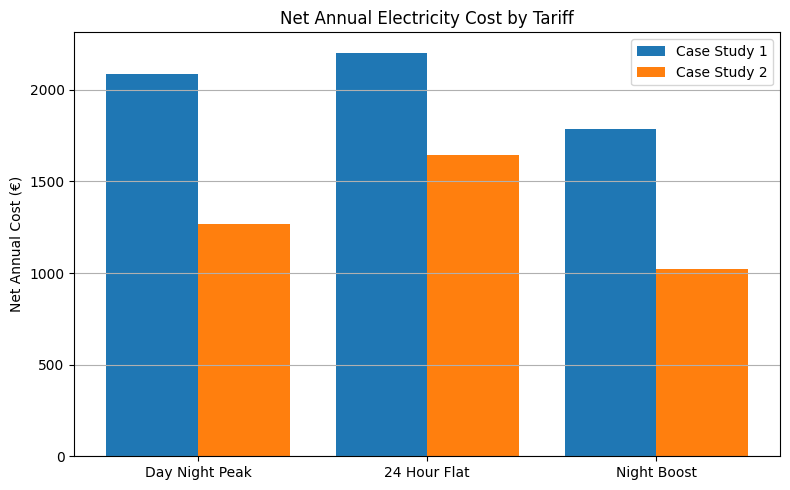

In [137]:
import matplotlib.pyplot as plt    # Import plotting library

annual_export_kwh = df_pv['PV_Export_kWh'].sum()    # Total measured solar PV export over the year

# The same solar PV system for both case studies
annual_export_case1 = annual_export_kwh    # Case Study 1 export
annual_export_case2 = annual_export_kwh    # Case Study 2 export


# Export revenue calculations

# Export revenue for Day Night Peak tariff
export_revenue_dnp_case1 = annual_export_case1 * tariff_day_night_peak['export_rate']
export_revenue_dnp_case2 = annual_export_case2 * tariff_day_night_peak['export_rate']

# Export revenue for Flat tariff
export_revenue_flat_case1 = annual_export_case1 * tariff_flat['export_rate']
export_revenue_flat_case2 = annual_export_case2 * tariff_flat['export_rate']

# Export revenue for Night Boost tariff
export_revenue_boost_case1 = annual_export_case1 * tariff_night_boost['export_rate']
export_revenue_boost_case2 = annual_export_case2 * tariff_night_boost['export_rate']


# Net annual electricity costs

# Case Study 1 net annual costs
net_cost_dnp_case1 = annual_cost_dnp_case1 - export_revenue_dnp_case1
net_cost_flat_case1 = annual_cost_flat_case1 - export_revenue_flat_case1
net_cost_boost_case1 = annual_cost_boost_case1 - export_revenue_boost_case1

# Case Study 2 net annual costs
net_cost_dnp_case2 = annual_cost_dnp_case2 - export_revenue_dnp_case2
net_cost_flat_case2 = annual_cost_flat_case2 - export_revenue_flat_case2
net_cost_boost_case2 = annual_cost_boost_case2 - export_revenue_boost_case2



print("Net Annual Electricity Costs\n")

print("Case Study 1 All Day Occupancy")
print(f"Day Night Peak: €{net_cost_dnp_case1:.2f}")
print(f"24 Hour Flat:   €{net_cost_flat_case1:.2f}")
print(f"Night Boost:    €{net_cost_boost_case1:.2f}\n")

print("Case Study 2 Away 9am to 5pm with EV")
print(f"Day Night Peak: €{net_cost_dnp_case2:.2f}")
print(f"24 Hour Flat:   €{net_cost_flat_case2:.2f}")
print(f"Night Boost:    €{net_cost_boost_case2:.2f}")


# Plot cost comparison charts

# Labels for tariffs
tariffs = ['Day Night Peak', '24 Hour Flat', 'Night Boost']

# Net cost values for plotting
case1_costs = [net_cost_dnp_case1, net_cost_flat_case1, net_cost_boost_case1]
case2_costs = [net_cost_dnp_case2, net_cost_flat_case2, net_cost_boost_case2]

# Side by side bar chart
x = range(len(tariffs))    # X positions for bars

plt.figure(figsize=(8, 5))    # Set figure size

plt.bar(x, case1_costs, width=0.4, label='Case Study 1', align='center')
plt.bar([i + 0.4 for i in x], case2_costs, width=0.4, label='Case Study 2', align='center')

plt.xticks([i + 0.2 for i in x], tariffs)    # Set x axis labels
plt.ylabel("Net Annual Cost (€)")            # Y axis label
plt.title("Net Annual Electricity Cost by Tariff")    # Plot title
plt.legend()                                 # Show legend
plt.grid(axis='y')                           # Add horizontal grid
plt.tight_layout()                           # Adjust layout
plt.show()


### Analysis of Surplus Solar PV Energy Stored in a Battery vs Exported to Grid 

A battery analysis is performed to compare the economic value of exporting surplus solar PV energy to the grid versus storing it in a 5kWh lithium ion storage battery for later use.

The analysis takes 100 percent round trip battery efficiency initially and focuses on its kWh value. More detailed battery degredation losses are analyzed later.

In [138]:
# Compare value of exporting 1 kWh of surplus PV versus storing it in a battery


battery_efficiency = 1.0    # 100 percent round trip efficiency assumed for simplicity

# Value of exporting 1 kWh of surplus PV under each tariff
export_value_dnp = tariff_day_night_peak['export_rate']     # Export value under Day Night Peak tariff
export_value_flat = tariff_flat['export_rate']              # Export value under Flat tariff 
export_value_boost = tariff_night_boost['export_rate']      # Export value under Night Boost tariff

# Value of using 1 kWh from battery to offset grid import
# Assumes battery discharges during higher cost day time periods
battery_value_peak = tariff_day_night_peak['peak_rate'] * battery_efficiency    # Offset peak import
battery_value_day = tariff_night_boost['day_rate'] * battery_efficiency          # Offset day import

# Print comparison
print("Battery vs Grid export value per kWh\n")

print("Export value per kWh")
print(f"Day Night Peak export: €{export_value_dnp:.3f}")
print(f"24 Hour Flat export:   €{export_value_flat:.3f}")
print(f"Night Boost export:    €{export_value_boost:.3f}\n")

print("Battery discharge value per kWh (ideal efficiency)")
print(f"Offset peak import: €{battery_value_peak:.3f}")
print(f"Offset day import:  €{battery_value_day:.3f}")


Battery vs Grid export value per kWh

Export value per kWh
Day Night Peak export: €0.185
24 Hour Flat export:   €0.185
Night Boost export:    €0.185

Battery discharge value per kWh (ideal efficiency)
Offset peak import: €0.308
Offset day import:  €0.301


#### Daily Solar PV Modelling - Monthly Inverter Data & Daily Irradiance Data from PVGIS

Monthly surplus PV export values are disaggregated into daily values using measured irradiance data from PVGIS (SARAH-2) service provided by the European Commission Joint Research Centre. The data is based on satellite derived irradiance products and correspond to the same 12 month period as the inverter and grid smart meter data This enables battery sizing and dispatch analysis while ensuring that total exported energy remains consistent with inverter data record measurements. This approach provides an accurate daily profile for surplus solar PV energy available for export or battery storage. It allows for accurate assessment of battery performance and economics based on actual solar generation patterns. Daily surplus values are required for accuate battery sizing and dispatch analysis.

#### Imported Daily Irradiance from PVGIS CSV File

The PVGIS irradiance data is provided as a semi structured CSV file containing metadata followed by tab delimited hourly data. 
The dataset represents measured satellite global irradiance for the year 2023 at the site location. 

The file was parsed locally to extract hourly global irradiance values, which are subsequently aggregated to daily totals. 
These daily irradiance profiles are later used to disaggregate monthly inverter export data and support battery sizing and dispatch analysis.


In [139]:
import pandas as pd

# Path to local PVGIS CSV file
pvgis_file_path = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\pvgis_timeseries_data.csv"

# Read PVGIS CSV
df_pvgis = pd.read_csv(
    pvgis_file_path,
    skiprows=9,          # Skip metadata rows so header is read correctly
    sep=",",             # Explicit separator
    engine="python"      # More tolerant CSV parser
)

# Keep only the expected data columns
df_pvgis = df_pvgis.iloc[:, [0, 1]]  # Select the first two columns based on their positions

# Rename columns to clearer names
# Inspect the actual column names in the DataFrame
print("Column names in the DataFrame:", df_pvgis.columns.tolist())

# Rename columns based on the actual column names
df_pvgis = df_pvgis.rename(columns={
    df_pvgis.columns[0]: 'DateTime',  # Rename the first column to 'DateTime'
    df_pvgis.columns[1]: 'Irradiance_Wm2'  # Rename the second column to 'Irradiance_Wm2'
})

# Convert DateTime column to pandas datetime
# PVGIS format: YYYYMMDD:HHMM
df_pvgis['DateTime'] = pd.to_datetime(
    df_pvgis['DateTime'],
    format='%Y%m%d:%H%M',
    errors='coerce'      # Drop any non-date junk safely
)

# Drop any rows that failed datetime conversion
df_pvgis = df_pvgis.dropna(subset=['DateTime'])

# Set DateTime as index
df_pvgis = df_pvgis.set_index('DateTime')

# Preview cleaned data
df_pvgis.head(3)


Column names in the DataFrame: ['20230101:0011', '0.0']


,Irradiance_Wm2
DateTime,
2023-01-01 01:11:00,0.0
2023-01-01 02:11:00,0.0
2023-01-01 03:11:00,0.0


#### Aggregated Daily Irradiance Data 

In [140]:
# Ensure irradiance column is numeric before aggregation

# Convert irradiance column to numeric (force errors to NaN)
df_pvgis['Irradiance_Wm2'] = pd.to_numeric(
    df_pvgis['Irradiance_Wm2'],
    errors='coerce'
)

# Create a Date column from the datetime index
df_pvgis['Date'] = df_pvgis.index.date

# Aggregate hourly irradiance to daily totals
daily_irradiance = (
    df_pvgis
    .groupby('Date')['Irradiance_Wm2']
    .sum()
    .reset_index()
)

# Rename for clarity
daily_irradiance = daily_irradiance.rename(
    columns={'Irradiance_Wm2': 'Daily_Irradiance'}
)

# Convert Date column back to datetime
daily_irradiance['Date'] = pd.to_datetime(daily_irradiance['Date'])

# Preview corrected result
daily_irradiance.head(8)


,Date,Daily_Irradiance
0,2023-01-01,482.91
1,2023-01-02,367.80
2,2023-01-03,292.87
3,2023-01-04,1044.61
4,2023-01-05,369.79
5,2023-01-06,776.94
6,2023-01-07,1424.48
7,2023-01-08,1160.77


#### Verify Aggregated Daily Irradiance Data 

In [141]:
# Check number of days and basic statistics
print("Number of days:", len(daily_irradiance))
print(daily_irradiance['Daily_Irradiance'].describe())


Number of days: 365
count     365.000000
mean     3188.064438
std      2206.954459
min       123.290000
25%      1404.940000
50%      2591.030000
75%      4823.320000
max      8594.910000
Name: Daily_Irradiance, dtype: float64


---
#### Machine Learning Based Disaggregation of Monthly Solar PV Export

- Prepare features from irradiance data
- Normalise monthly export into daily targets
- Train regression model
- Predict daily export weights
- Re-scale to match monthly export totals

---

#### Prepare Daily Irradiance for Monthly Allocation

In [142]:
# Ensure Date column is datetime
daily_irradiance['Date'] = pd.to_datetime(daily_irradiance['Date'])

# Create Month column to match inverter export data
daily_irradiance['Month'] = daily_irradiance['Date'].dt.to_period('M').dt.to_timestamp()

# Quick check
daily_irradiance.head()

,Date,Daily_Irradiance,Month
0,2023-01-01,482.91,2023-01-01
1,2023-01-02,367.80,2023-01-01
2,2023-01-03,292.87,2023-01-01
3,2023-01-04,1044.61,2023-01-01
4,2023-01-05,369.79,2023-01-01


#### Monthly Normalised Irradiance Weights

In [143]:
# Calculate total irradiance per month
monthly_irradiance_sum = (
    daily_irradiance
    .groupby('Month')['Daily_Irradiance']
    .sum()
)

# Map monthly totals back to daily data
daily_irradiance['Monthly_Irradiance_Total'] = daily_irradiance['Month'].map(monthly_irradiance_sum)

# Calculate daily irradiance weight within each month
daily_irradiance['Irradiance_Weight'] = (
    daily_irradiance['Daily_Irradiance'] /
    daily_irradiance['Monthly_Irradiance_Total']
)

# Sanity check: weights should sum to 1 per month
daily_irradiance.groupby('Month')['Irradiance_Weight'].sum().head()

Month
2023-01-01    1.0
2023-02-01    1.0
2023-03-01    1.0
2023-04-01    1.0
2023-05-01    1.0
Name: Irradiance_Weight, dtype: float64

#### Feature Engineering from Daily Irradiance Data

In [144]:
# Import scikit learn regression model
from sklearn.linear_model import LinearRegression

# Feature: daily irradiance (reshape required for sklearn)
X = daily_irradiance[['Daily_Irradiance']]    # Predictor variable

# Target: normalized irradiance weight (acts as proxy for export share)
y = daily_irradiance['Irradiance_Weight']     # Target variable



#### Train the Regression Model

In [145]:
# Create linear regression model
irradiance_model = LinearRegression()

# Fit model to data
irradiance_model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Predict Daily Export Weights

In [146]:
# Predict daily weights using trained model
daily_irradiance['Predicted_Weight'] = irradiance_model.predict(X)

# Ensure no negative values
daily_irradiance['Predicted_Weight'] = daily_irradiance['Predicted_Weight'].clip(lower=0)

# Renormalize so weights sum to 1
daily_irradiance['Predicted_Weight'] = (
    daily_irradiance['Predicted_Weight'] /
    daily_irradiance['Predicted_Weight'].sum()
)


#### Convert Inverter Excel Data to CSV Format

In [147]:
import pandas as pd                               # Import pandas for data handling

# Path to the inverter Excel file
excel_path = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Solis Cloud Data Logger - 2025..xlsx"

# Path where the CSV will be saved
csv_path = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Solis_Cloud_Data_Logger_2025.csv"

# Read the Excel file
df_solar = pd.read_excel(excel_path)              # Load inverter data from Excel

# Save to CSV
df_solar.to_csv(csv_path, index=False)            # Export data to CSV format

# Confirm output
csv_path



'C:\\Users\\CAD-PC\\Desktop\\GitHub - Cloned Repository\\PFDA\\Project\\Solis_Cloud_Data_Logger_2025.csv'

#### Load Inverter Data from CSV Dataset

In [148]:
# Import pandas for data handling
import pandas as pd

# File path to inverter export data (converted from Excel to CSV)
inverter_csv_path = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Solis_Cloud_Data_Logger_2025.csv"

# Load inverter data into DataFrame
df_inverter = pd.read_csv(inverter_csv_path)

# Display first few rows to inspect structure
df_inverter.head()


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Time,SPV Monthly Yield(kWh),SPV Monthly Energy to Grid(kWh)
1,NaN,12/2024,110.4,27
2,NaN,01/2025,238,80
3,NaN,02/2025,298,156
4,NaN,03/2025,687,398


#### Load Monthly Inverter Export Data

In [149]:
# Load monthly Solar PV export data from inverter logger

import pandas as pd    # Data handling

# Path to inverter export data
pv_export_file = r"C:\Users\CAD-PC\Desktop\GitHub - Cloned Repository\PFDA\Project\Solis Cloud Data Logger - 2025..xlsx"

# Read Excel file, skipping the first row to avoid header issues
monthly_export = pd.read_excel(pv_export_file, skiprows=1)

# Inspect the actual column names in the DataFrame
print("Column names in the DataFrame:", monthly_export.columns.tolist())

# Keep only relevant columns based on actual column names
monthly_export = monthly_export[['Time', 'SPV Monthly Energy to Grid(kWh)']]

# Drop rows with invalid or missing dates
monthly_export = monthly_export.dropna(subset=['Time'])

# Convert Time to datetime
monthly_export['Time'] = pd.to_datetime(monthly_export['Time'], format='%m/%Y', errors='coerce')

# Drop rows where the date conversion failed
monthly_export = monthly_export.dropna(subset=['Time'])

monthly_export


Column names in the DataFrame: ['Unnamed: 0', 'Time', 'SPV Monthly Yield(kWh)', 'SPV Monthly Energy to Grid(kWh)']


,Time,SPV Monthly Energy to Grid(kWh)
0,2024-12-01,27
1,2025-01-01,80
2,2025-02-01,156
3,2025-03-01,398
4,2025-04-01,725
5,2025-05-01,909
6,2025-06-01,719
7,2025-07-01,535
8,2025-08-01,540
9,2025-09-01,284


In [ ]:
# Clean Month Number column and merge monthly export into daily irradiance 

# Daily data (2023)
daily_irradiance['MonthNum'] = daily_irradiance['Date'].dt.month

# Monthly Export data (2024–2025)
monthly_export = monthly_export.rename(columns={
    'Time': 'Month',
    'SPV Monthly Energy to Grid(kWh)': 'Monthly_Export_kWh'
})

monthly_export['Month'] = pd.to_datetime(monthly_export['Month'])
monthly_export['MonthNum'] = monthly_export['Month'].dt.month

# Keep only MonthNum + export
monthly_export = monthly_export[['MonthNum', 'Monthly_Export_kWh']]

# Remove any old export column
daily_irradiance = daily_irradiance.drop(
    columns=['Monthly_Export_kWh'],
    errors='ignore'
)

# Merge monthly export into daily irradiance DataFrame
daily_irradiance = daily_irradiance.merge(
    monthly_export,
    on='MonthNum',
    how='left'
)

# Test output
daily_irradiance[['Date', 'MonthNum', 'Monthly_Export_kWh']].head(15)


,Date,MonthNum,Monthly_Export_kWh
0,2023-01-01,1,80
1,2023-01-02,1,80
2,2023-01-03,1,80
3,2023-01-04,1,80
4,2023-01-05,1,80
5,2023-01-06,1,80
6,2023-01-07,1,80
7,2023-01-08,1,80
8,2023-01-09,1,80
9,2023-01-10,1,80


#### Allocate Monthly Export into Daily Export Using Machine Learning Derived Weights

In [151]:
# Create monthly normalised irradiance weights
daily_irradiance['Monthly_Irradiance_Weight'] = (
    daily_irradiance['Daily_Irradiance'] /
    daily_irradiance.groupby('Month')['Daily_Irradiance'].transform('sum')
)




In [152]:
# Allocate monthly export correctly using monthly normalised weights
daily_irradiance['Daily_Export_kWh'] = (
    daily_irradiance['Monthly_Irradiance_Weight'] *
    daily_irradiance['Monthly_Export_kWh']
)


In [153]:
# Create monthly normalised irradiance weights

daily_irradiance['Monthly_Irradiance_Total'] = (
    daily_irradiance
    .groupby('Month')['Daily_Irradiance']
    .transform('sum')
)

daily_irradiance['Monthly_Irradiance_Weight'] = (
    daily_irradiance['Daily_Irradiance'] /
    daily_irradiance['Monthly_Irradiance_Total']
)


In [154]:
daily_irradiance.groupby('Month')['Monthly_Irradiance_Weight'].sum()


Month
2023-01-01    1.0
2023-02-01    1.0
2023-03-01    1.0
2023-04-01    1.0
2023-05-01    1.0
2023-06-01    1.0
2023-07-01    1.0
2023-08-01    1.0
2023-09-01    1.0
2023-10-01    1.0
2023-11-01    1.0
2023-12-01    1.0
Name: Monthly_Irradiance_Weight, dtype: float64

In [155]:
# Allocate monthly export energy into daily values using monthly irradiance weights

daily_irradiance['Daily_Export_kWh'] = (
    daily_irradiance['Monthly_Irradiance_Weight'] *
    daily_irradiance['Monthly_Export_kWh']
)


In [156]:
# Validate that daily exports sum back to monthly values
daily_irradiance.groupby('Month')['Daily_Export_kWh'].sum()


Month
2023-01-01     80.0
2023-02-01    156.0
2023-03-01    398.0
2023-04-01    725.0
2023-05-01    909.0
2023-06-01    719.0
2023-07-01    535.0
2023-08-01    540.0
2023-09-01    284.0
2023-10-01     83.0
2023-11-01     33.0
2023-12-01     27.0
Name: Daily_Export_kWh, dtype: float64

---

Monthly inverter export data is disaggregated into daily values using irradiance based weighting derived from PVGIS hourly irradiance data.
This enables realistic battery sizing and dispatch analysis at daily resolution while preserving measured monthly export totals.

---

#### Annual Value of Storing Surplus Solar PV Energy in a Battery vs Exporting to the Grid

- Battery round trip efficiency 100% (Will be varied later)
- No battery degradation (Will be varied later)
- No battery cycle limits (Will be varied later)
- Same solarPV system used in both case studies

If all surplus PV energy is exported to the grid, the annual revenue can be calculated using the applicable export tariff.

When surplus PV energy is stored in a battery and used later, it offsets grid electricity imports. The financial value of stored energy therefore depends on the tariff that would otherwise have been paid at the time of use.

- This comparison ignores battery upfront capital cost
- It measures maximum annual economic value a battery could deliver
- Battery degradation, cycling and dept of discharge will be compared later against this value

In [157]:
# Annual value of exporting surplus PV vs storing it in a battery

# Redefine electricity tariff rates in euro per kWh and annual standing charges
tariff_day_night_peak = {
	'day_rate': 0.3079,        # Day rate in euro per kWh
	'night_rate': 0.1517,      # Night rate in euro per kWh (Summer midnight to 9am) (Winter 11pm to 8am)
	'peak_rate': 0.3079,       # Peak rate (5pm to 7pm)
	'export_rate': 0.1850,     # Export feed in tariff
	'standing_charge': 314.19  # Annual standing charge in euro
}

tariff_flat = {
	'flat_rate': 0.2586,       # Single rate applied all day
	'export_rate': 0.1850,     # Export feed in tariff
	'standing_charge': 314.19  # Annual standing charge in euro
}

tariff_night_boost = {
	'day_rate': 0.30053,       # Day rate in euro per kWh
	'night_rate': 0.1505,      # Standard night rate (Summer midnight to 9am) (Winter 11pm to 8am)
	'boost_rate': 0.0884,      # Night boost rate (2am to 4am)
	'export_rate': 0.1850,     # Export feed in tariff
	'standing_charge': 400.18  # Higher annual standing charge
}

# Export tariff rates (€/kWh)
export_rate_dnp = tariff_day_night_peak['export_rate']      # Export rate for Day/Night/Peak tariff
export_rate_flat = tariff_flat['export_rate']               # Export rate for 24-hour flat tariff
export_rate_boost = tariff_night_boost['export_rate']       # Export rate for Night Boost tariff

# Import tariff rates used to value stored energy (€/kWh)
day_rate_dnp = tariff_day_night_peak['day_rate']            # Day import rate for Day/Night/Peak tariff
flat_rate = tariff_flat['flat_rate']                        # Flat import rate for 24-hour flat tariff
day_rate_boost = tariff_night_boost['day_rate']             # Day import rate for Night Boost tariff

# Annual surplus PV energy (kWh) based on inverter export values
annual_surplus_kwh = monthly_export['Monthly_Export_kWh'].sum()    # Sum monthly export kWh

# Annual export revenue for each tariff option (€)
export_value_dnp = annual_surplus_kwh * export_rate_dnp            # Export revenue under Day/Night/Peak
export_value_flat = annual_surplus_kwh * export_rate_flat          # Export revenue under flat tariff
export_value_boost = annual_surplus_kwh * export_rate_boost        # Export revenue under Night Boost

# Annual value of storing that surplus in a battery (€)
# Assumption: stored energy offsets imports at the day (or flat) rate, and battery efficiency is 100%
battery_value_dnp = annual_surplus_kwh * day_rate_dnp              # Value if surplus offsets day imports under DNP
battery_value_flat = annual_surplus_kwh * flat_rate                # Value if surplus offsets imports under flat tariff
battery_value_boost = annual_surplus_kwh * day_rate_boost          # Value if surplus offsets day imports under Night Boost

# Net advantage of battery storage over exporting (€)
battery_advantage_dnp = battery_value_dnp - export_value_dnp        # Battery vs export advantage under DNP
battery_advantage_flat = battery_value_flat - export_value_flat     # Battery vs export advantage under flat tariff
battery_advantage_boost = battery_value_boost - export_value_boost  # Battery vs export advantage under Night Boost

# Print results
print("Annual Surplus PV Energy (kWh):", round(annual_surplus_kwh, 2), "\n")

print("Annual Export Revenue (€)")
print("Day/Night/Peak:", round(export_value_dnp, 2))
print("24 Hour Flat:  ", round(export_value_flat, 2))
print("Night Boost:   ", round(export_value_boost, 2), "\n")

print("Annual Value if Stored in Battery (€)")
print("Day/Night/Peak:", round(battery_value_dnp, 2))
print("24 Hour Flat:  ", round(battery_value_flat, 2))
print("Night Boost:   ", round(battery_value_boost, 2), "\n")

print("Battery Advantage over Export (€)")
print("Day/Night/Peak:", round(battery_advantage_dnp, 2))
print("24 Hour Flat:  ", round(battery_advantage_flat, 2))
print("Night Boost:   ", round(battery_advantage_boost, 2))


Annual Surplus PV Energy (kWh): 4489 

Annual Export Revenue (€)
Day/Night/Peak: 830.46
24 Hour Flat:   830.46
Night Boost:    830.46 

Annual Value if Stored in Battery (€)
Day/Night/Peak: 1382.16
24 Hour Flat:   1160.86
Night Boost:    1349.08 

Battery Advantage over Export (€)
Day/Night/Peak: 551.7
24 Hour Flat:   330.39
Night Boost:    518.61


#### Bar Chart - Annual Value of Battery Storage vs Export to Grid

At this stage, the analysis considers the maximum theoretical value of the surplus solar PV energy, independent of household usage behaviour.
Differences between Case Study 1 and Case Study 2 are introduced in a subsequent section through daily load matching and battery dispatch modelling.

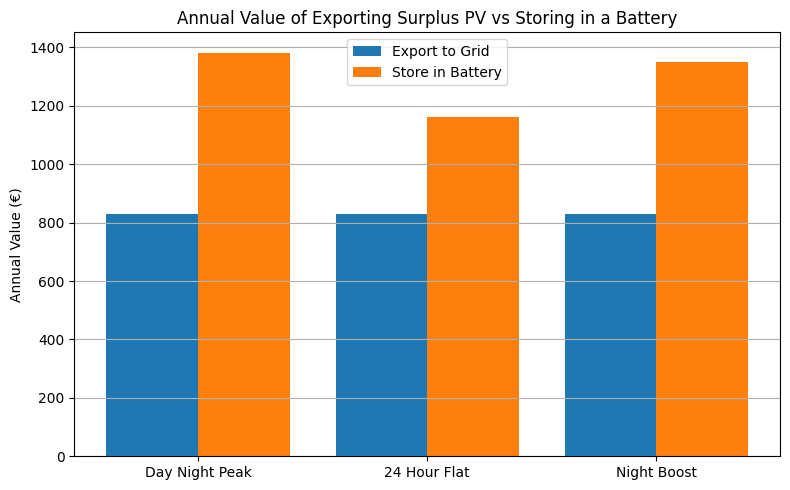

In [158]:
import matplotlib.pyplot as plt    # Plotting library

# Labels for comparison
labels = ['Day Night Peak', '24 Hour Flat', 'Night Boost']

# Values to plot
export_values = [
    export_value_dnp,
    export_value_flat,
    export_value_boost
]

battery_values = [
    battery_value_dnp,
    battery_value_flat,
    battery_value_boost
]

# X positions for bars
x = range(len(labels))

# Create bar chart
plt.figure(figsize=(8, 5))

# Export value bars
plt.bar(
    x,
    export_values,
    width=0.4,
    label='Export to Grid',
    align='center'
)

# Battery value bars (offset to the right)
plt.bar(
    [i + 0.4 for i in x],
    battery_values,
    width=0.4,
    label='Store in Battery',
    align='center'
)

# Axis labels
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel("Annual Value (€)")
plt.title("Annual Value of Exporting Surplus PV vs Storing in a Battery")

# Add grid and legend
plt.grid(axis='y')
plt.legend()

# Layout adjustment
plt.tight_layout()

# Show plot
plt.show()


#### Daily Load Energy vs Solar PV Generation 

In [164]:
# Create average hourly load profile for Case Study 1

# Melt 30 minute interval columns into long format
case1_long = df_case1.melt(
    id_vars='Date',
    value_vars=interval_cols_case1,
    var_name='Time',
    value_name='kWh'
)

# Convert time strings to datetime time
case1_long['Time'] = pd.to_datetime(case1_long['Time'], format='%H:%M:%S').dt.time

# Create hour column
case1_long['Hour'] = case1_long['Time'].apply(lambda t: t.hour)

# Average load per hour across all days
avg_load_case1 = case1_long.groupby('Hour')['kWh'].mean()

# Hour axis
hours = avg_load_case1.index


In [165]:
# Create average hourly load profile for Case Study 2

case2_long = df_case2.melt(
    id_vars='Date',
    value_vars=interval_cols_case2,
    var_name='Time',
    value_name='kWh'
)

case2_long['Time'] = pd.to_datetime(case2_long['Time'], format='%H:%M:%S').dt.time
case2_long['Hour'] = case2_long['Time'].apply(lambda t: t.hour)

avg_load_case2 = case2_long.groupby('Hour')['kWh'].mean()


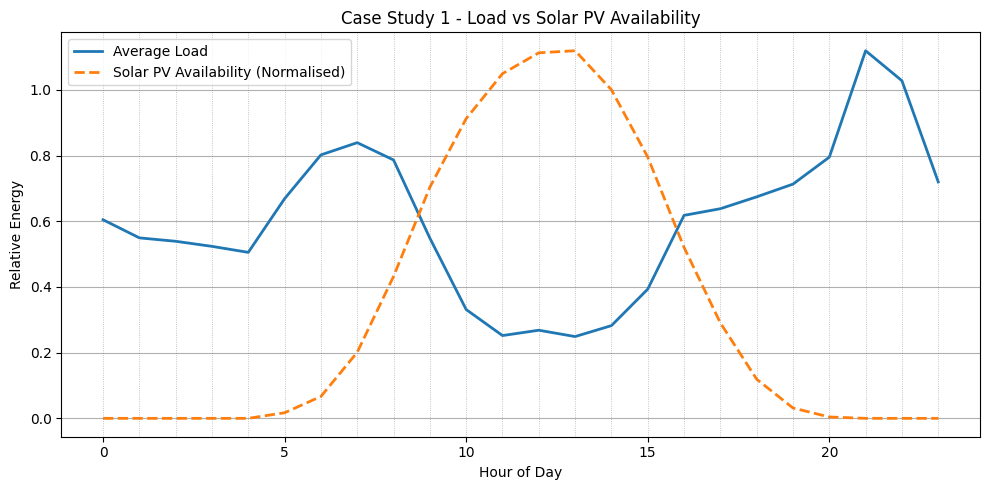

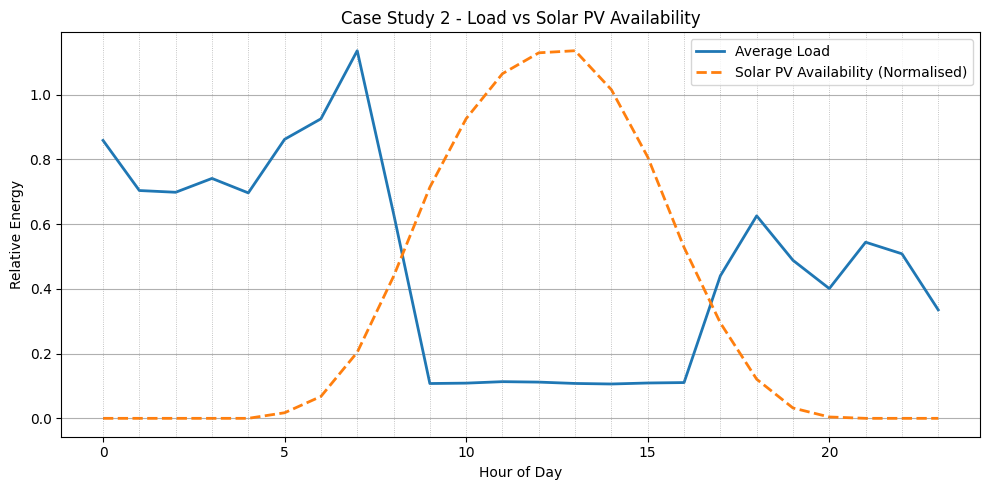

In [166]:
# Create average daily irradiance profile (shape only)

# Group PVGIS irradiance data by hour of day
daily_irr_profile = (
    df_pvgis
    .groupby(df_pvgis.index.hour)['Irradiance_Wm2']
    .mean()
)

# Normalise irradiance to 0–1 scale for shape comparison
pv_shape = daily_irr_profile / daily_irr_profile.max()

# Create hour axis for plotting
pv_hours = daily_irr_profile.index




# Plot Case Study 1 with PV shape
plt.figure(figsize=(10, 5))

plt.plot(hours, avg_load_case1, label='Average Load', linewidth=2)
plt.plot(
    pv_hours,
    pv_shape * avg_load_case1.max(),
    label='Solar PV Availability (Normalised)',
    linestyle='--',
    linewidth=2
)

# Hourly vertical lines
for h in range(24):
    plt.axvline(h, color='grey', linestyle=':', linewidth=0.6, alpha=0.6)

plt.xlabel("Hour of Day")
plt.ylabel("Relative Energy")
plt.title("Case Study 1 - Load vs Solar PV Availability")
plt.legend()
plt.grid(True, axis='y')   # keep horizontal grid only
plt.tight_layout()
plt.show()






# Plot Case Study 2 with PV shape
plt.figure(figsize=(10, 5))

plt.plot(hours, avg_load_case2, label='Average Load', linewidth=2)
plt.plot(
    pv_hours,
    pv_shape * avg_load_case2.max(),
    label='Solar PV Availability (Normalised)',
    linestyle='--',
    linewidth=2
)

# Hourly vertical lines
for h in range(24):
    plt.axvline(h, color='grey', linestyle=':', linewidth=0.6, alpha=0.6)

plt.xlabel("Hour of Day")
plt.ylabel("Relative Energy")
plt.title("Case Study 2 - Load vs Solar PV Availability")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



#### Annual Theoretical Value of Surplus Solar PV Energy Stored in Battery vs Exported to Grid 

Annual PV Surplus Battery vs Export (Simple Model)

Annual surplus PV exported (kWh): 4,489.00
Export value (€/year):           €830.47
Battery value (€/year):          €1,349.08
Battery minus export (€/year):   €518.61

Indicative battery size from daily surplus distribution
P50 (median daily surplus): 9.42 kWh
P75:                        19.98 kWh
P90:                        29.80 kWh
P95:                        34.79 kWh


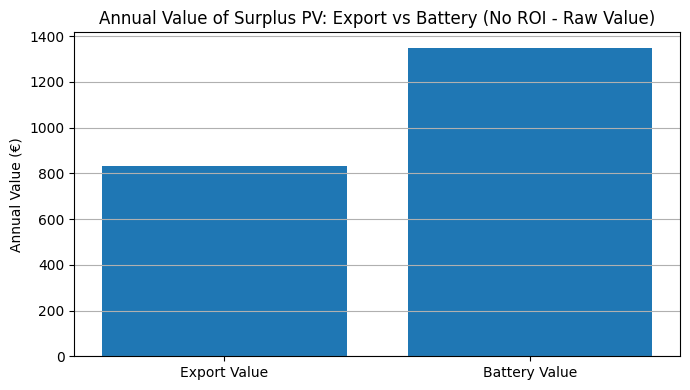

In [172]:
import numpy as np                                              # Numerical operations
import pandas as pd                                             # Data handling
import matplotlib.pyplot as plt                                 # Plotting

# Battery assumptions (simple for now)
battery_round_trip_eff = 1.0                                    # 100% efficiency for now
battery_usable_fraction = 1.0                                   # Assume full usable capacity for now (change later)

# Avoided import cost
avoided_import_rate = tariff_night_boost['day_rate']            # €/kWh avoided when battery discharges

# Export revenue rate (same PV system for both case studies)
export_rate = tariff_night_boost['export_rate']                 # €/kWh earned when exporting

# Ensure Daily_Export_kWh exists and is numeric
daily_irradiance['Daily_Export_kWh'] = pd.to_numeric(            # Force numeric
    daily_irradiance['Daily_Export_kWh'],
    errors='coerce'
)

# Drop missing daily export values (if any)
daily_export = daily_irradiance.dropna(subset=['Daily_Export_kWh']).copy()   # Keep valid rows only

# Annual exported surplus (kWh)
annual_surplus_kwh = daily_export['Daily_Export_kWh'].sum()      # Total annual PV surplus exported

# Annual value if always exported (revenue)
annual_export_value = annual_surplus_kwh * export_rate           # €/year earned by export

# Annual value if stored and used later (avoided imports)
annual_battery_value = annual_surplus_kwh * avoided_import_rate * battery_round_trip_eff   # €/year avoided import cost

# Net benefit of battery vs exporting (ignoring battery capex)
annual_battery_minus_export = annual_battery_value - annual_export_value    # €/year extra value vs export

# Battery capacity sizing from daily surplus distribution
p50_size = np.percentile(daily_export['Daily_Export_kWh'], 50)   # Median daily surplus (kWh)
p75_size = np.percentile(daily_export['Daily_Export_kWh'], 75)   # 75th percentile daily surplus (kWh)
p90_size = np.percentile(daily_export['Daily_Export_kWh'], 90)   # 90th percentile daily surplus (kWh)
p95_size = np.percentile(daily_export['Daily_Export_kWh'], 95)   # 95th percentile daily surplus (kWh)

# Adjust for usable capacity fraction
p50_size = p50_size / battery_usable_fraction                    # Required nominal capacity
p75_size = p75_size / battery_usable_fraction                    # Required nominal capacity
p90_size = p90_size / battery_usable_fraction                    # Required nominal capacity
p95_size = p95_size / battery_usable_fraction                    # Required nominal capacity

# Print summary results
print("Annual PV Surplus Battery vs Export (Simple Model)\n")     # Header text

print(f"Annual surplus PV exported (kWh): {annual_surplus_kwh:,.2f}")                         # Annual surplus
print(f"Export value (€/year):           €{annual_export_value:,.2f}")                        # Export revenue
print(f"Battery value (€/year):          €{annual_battery_value:,.2f}")                       # Avoided import value
print(f"Battery minus export (€/year):   €{annual_battery_minus_export:,.2f}\n")              # Net advantage

print("Indicative battery size from daily surplus distribution")                              # Battery sizing info
print(f"P50 (median daily surplus): {p50_size:,.2f} kWh")                                     # Median size
print(f"P75:                        {p75_size:,.2f} kWh")                                     # 75th percentile
print(f"P90:                        {p90_size:,.2f} kWh")                                     # 90th percentile
print(f"P95:                        {p95_size:,.2f} kWh")                                     # 95th percentile

# Bar chart of export vs battery value
labels = ['Export Value', 'Battery Value']                                        # Two bars
values = [annual_export_value, annual_battery_value]                              # €/year values

plt.figure(figsize=(7, 4))                                                        # Set figure size
plt.bar(labels, values)                                                           # Plot bars
plt.ylabel("Annual Value (€)")                                                    # Y axis label
plt.title("Annual Value of Surplus PV: Export vs Battery (No ROI - Raw Value)")     # Title
plt.grid(axis='y')                                                                # Horizontal grid
plt.tight_layout()                                                                # Clean layout
plt.show()                                                                        # Render plot


#### Battery Sizing Metrics - Based on ML Disaggregated Daily Export Profiles

Annual surplus PV (export proxy) = 4489.00 kWh
Daily surplus sizing stats (kWh/day): P90=29.80, P95=34.79, Max=46.50


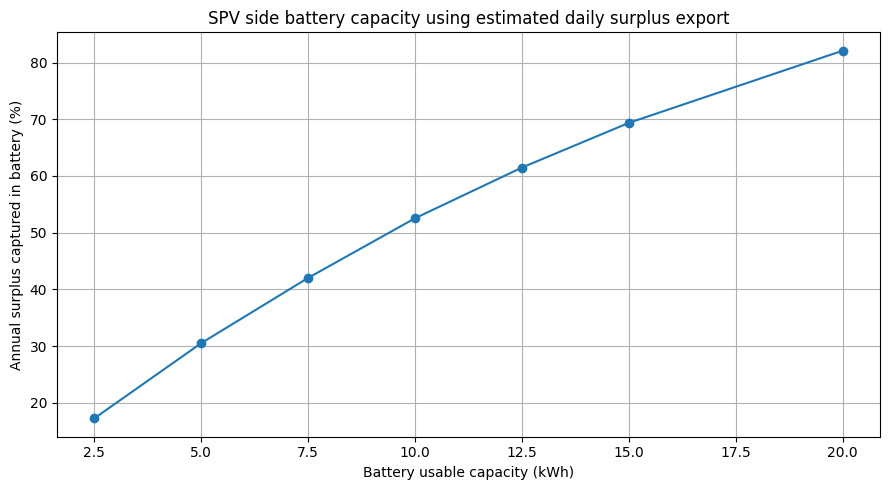

Recommended SPV side battery capacity (captures ≥ 90% of annual surplus): 20.0 kWh


In [171]:
import numpy as np                                  # Numerical tools for percentile and array ops
import pandas as pd                                 # Data handling
import matplotlib.pyplot as plt                     # Plotting

# Ensure the daily surplus export column exists before sizing
if 'Daily_Export_kWh' not in daily_irradiance.columns:                               # Check required column exists
    raise KeyError("Missing 'Daily_Export_kWh' in daily_irradiance. Run the daily allocation cell first.")  # Stop with clear message

# Make a clean working copy and keep only valid daily values
pv_surplus = daily_irradiance[['Date', 'Daily_Export_kWh']].copy()                  # Copy only columns we need
pv_surplus['Daily_Export_kWh'] = pd.to_numeric(pv_surplus['Daily_Export_kWh'], errors='coerce')  # Force numeric
pv_surplus = pv_surplus.dropna(subset=['Daily_Export_kWh'])                         # Drop rows where conversion failed
pv_surplus = pv_surplus[pv_surplus['Daily_Export_kWh'] >= 0]                        # Remove any negative values if present

# Annual surplus PV exported (used as proxy for "available surplus to store")
annual_surplus_kwh = pv_surplus['Daily_Export_kWh'].sum()                           # Total annual surplus energy (kWh)

# Basic sizing statistics from daily surplus distribution
p90_kwh = np.percentile(pv_surplus['Daily_Export_kWh'], 90)                         # 90th percentile daily surplus (kWh/day)
p95_kwh = np.percentile(pv_surplus['Daily_Export_kWh'], 95)                         # 95th percentile daily surplus (kWh/day)
max_kwh = pv_surplus['Daily_Export_kWh'].max()                                      # Max daily surplus (kWh/day)

# Choose battery capacity candidates in kWh (edit this list freely)
capacity_options_kwh = [2.5, 5, 7.5, 10, 12.5, 15, 20]                              # Candidate usable battery capacities (kWh)

# Calculate how much surplus each battery size could capture (PV-side only, best case)
results = []                                                                        # Store results for each capacity
for cap in capacity_options_kwh:                                                    # Loop candidate sizes
    captured_kwh = np.minimum(pv_surplus['Daily_Export_kWh'], cap).sum()            # Capture per day limited by capacity, summed over year
    captured_pct = (captured_kwh / annual_surplus_kwh) * 100 if annual_surplus_kwh > 0 else 0  # Percent captured
    results.append([cap, captured_kwh, captured_pct])                               # Append row to results

# Convert results to DataFrame for display and later plotting
battery_sizing = pd.DataFrame(results, columns=['Battery_kWh', 'Annual_Captured_kWh', 'Captured_%'])  # Create results table

# Print key summary numbers
print(f"Annual surplus PV (export proxy) = {annual_surplus_kwh:.2f} kWh")           # Print annual surplus
print(f"Daily surplus sizing stats (kWh/day): P90={p90_kwh:.2f}, P95={p95_kwh:.2f}, Max={max_kwh:.2f}")  # Print percentiles

# Show the sizing table
battery_sizing                                                                            # Display sizing table in notebook

# Plot: percent of annual surplus captured vs battery size
plt.figure(figsize=(9, 5))                                                          # Create figure
plt.plot(battery_sizing['Battery_kWh'], battery_sizing['Captured_%'], marker='o')    # Line plot with markers
plt.xlabel("Battery usable capacity (kWh)")                                          # X label
plt.ylabel("Annual surplus captured in battery (%)")                                            # Y label
plt.title("SPV side battery capacity using estimated daily surplus export") # Title
plt.grid(True)                                                                        # Grid for readability
plt.tight_layout()                                                                    # Layout
plt.show()                                                                            # Render plot

# Optional: pick a simple recommendation rule (smallest capacity that captures at least 90%)
target_capture_pct = 90                                                              # Target capture threshold (%)
eligible = battery_sizing[battery_sizing['Captured_%'] >= target_capture_pct]        # Filter capacities meeting target
recommended_kwh = eligible['Battery_kWh'].iloc[0] if len(eligible) > 0 else battery_sizing['Battery_kWh'].iloc[-1]  # Choose smallest meeting target
print(f"Recommended SPV side battery capacity (captures ≥ {target_capture_pct}% of annual surplus): {recommended_kwh} kWh")  # Print recommendation


#### Battery Dispatch vs Case Study 1 Load Profile - Real Value of Battery Storage

In [176]:
import numpy as np                                              # Import numpy for vectorised min() and numeric ops
import pandas as pd                                             # Import pandas for data handling

# ---- SETTINGS (edit these values) ----
battery_sizes_kwh = [2.5, 5, 7.5, 10, 12.5, 15]                 # Candidate usable battery capacities (kWh)
battery_round_trip_eff = 1.00                                   # Battery round trip efficiency (1.00 = 100%)
export_rate_eur_per_kwh = 0.185                                  # Export tariff used for "opportunity cost" of storing instead of exporting (€ / kWh)
rates_dnp = {'day': 0.3079, 'night': 0.1517, 'peak': 0.3079}     # Day Night Peak import rates (€ / kWh) (peak assumed same as day unless you set otherwise)

# ---- REQUIRED INPUT CHECKS ----
if 'Date' not in df_case1.columns:                               # Check required Date column exists in Case Study 1
    raise KeyError("df_case1 missing 'Date' column.")            # Stop with a clear message
if 'Day_kWh' not in df_case1.columns or 'Night_kWh' not in df_case1.columns or 'Peak_kWh' not in df_case1.columns:  # Check the split columns exist
    raise KeyError("df_case1 missing Day_kWh / Night_kWh / Peak_kWh. Run the day/night/peak split cell first.")      # Stop with a clear message
if 'Daily_Export_kWh' not in daily_irradiance.columns or 'Date' not in daily_irradiance.columns:  # Check PV daily export estimate exists
    raise KeyError("daily_irradiance must contain 'Date' and 'Daily_Export_kWh'. Run the PV daily allocation cell first.")  # Stop with a clear message

# ---- ALIGN PV DAILY SURPLUS (2023 proxy) TO CASE STUDY 1 DATES ----
pv_proxy = daily_irradiance[['Date', 'Daily_Export_kWh']].copy()  # Copy the PV proxy daily export series
pv_proxy['Date'] = pd.to_datetime(pv_proxy['Date'])               # Ensure PV proxy Date is datetime
pv_proxy['MonthDay'] = pv_proxy['Date'].dt.strftime('%m-%d')      # Create a month-day key (MM-DD) for mapping across years
pv_proxy['Daily_Export_kWh'] = pd.to_numeric(pv_proxy['Daily_Export_kWh'], errors='coerce')  # Force numeric PV export values
pv_proxy = pv_proxy.dropna(subset=['Daily_Export_kWh'])           # Drop rows that could not be converted to numeric
pv_map = pv_proxy.groupby('MonthDay')['Daily_Export_kWh'].mean()  # Build a mapping from MM-DD to typical daily export (kWh)

case1 = df_case1.copy()                                           # Work on a copy to keep original clean
case1['Date'] = pd.to_datetime(case1['Date'])                     # Ensure Case Study 1 Date is datetime
case1 = case1.dropna(subset=['Date'])                             # Drop any blank Date rows
case1['MonthDay'] = case1['Date'].dt.strftime('%m-%d')            # Create the same MM-DD key for Case Study 1
case1['PV_Surplus_kWh'] = case1['MonthDay'].map(pv_map)           # Map PV surplus estimate onto each Case Study 1 day
case1['PV_Surplus_kWh'] = case1['PV_Surplus_kWh'].fillna(0.0)     # Fill any unmatched days with 0 surplus

# ---- BATTERY DISPATCH (BEST CASE) AGAINST CASE STUDY 1 LOAD ----
# Rule: discharge to Peak first, then Day, then Night (because peak is typically most valuable)
results = []                                                      # Create an empty list to store results per battery size

annual_pv_surplus_kwh = case1['PV_Surplus_kWh'].sum()             # Compute annual PV surplus available (kWh) over Case Study 1 dates
annual_export_value_eur = annual_pv_surplus_kwh * export_rate_eur_per_kwh  # Compute annual export revenue if all surplus was exported (€)

for cap in battery_sizes_kwh:                                     # Loop through each candidate battery size
    stored_kwh = np.minimum(case1['PV_Surplus_kWh'], cap)         # Compute daily energy that can be stored (kWh) limited by capacity
    stored_kwh = stored_kwh * battery_round_trip_eff             # Apply round-trip efficiency to stored energy (kWh usable)

    peak_offset_kwh = np.minimum(stored_kwh, case1['Peak_kWh'])   # Offset peak imports first (kWh)
    rem_after_peak = stored_kwh - peak_offset_kwh                 # Remaining stored energy after peak offset (kWh)

    day_offset_kwh = np.minimum(rem_after_peak, case1['Day_kWh']) # Offset day imports next (kWh)
    rem_after_day = rem_after_peak - day_offset_kwh               # Remaining stored energy after day offset (kWh)

    night_offset_kwh = np.minimum(rem_after_day, case1['Night_kWh'])  # Offset night imports last (kWh)

    avoided_cost_eur = (peak_offset_kwh.sum() * rates_dnp['peak']) + (day_offset_kwh.sum() * rates_dnp['day']) + (night_offset_kwh.sum() * rates_dnp['night'])  # Compute avoided import cost (€)
    net_value_vs_export_eur = avoided_cost_eur - (stored_kwh.sum() * export_rate_eur_per_kwh)  # Compare storing vs exporting only the energy actually stored (€)

    results.append([cap, stored_kwh.sum(), avoided_cost_eur, stored_kwh.sum() * export_rate_eur_per_kwh, net_value_vs_export_eur])  # Store results row

battery_case1_value = pd.DataFrame(                               # Convert results list into a DataFrame
    results,                                                      # Use computed results
    columns=['Battery_kWh', 'Energy_Stored_kWh', 'Avoided_Import_€', 'Lost_Export_€', 'Net_Value_vs_Export_€']  # Name output columns
)

battery_case1_value                                                # Display the Case Study 1 battery value table







,Battery_kWh,Energy_Stored_kWh,Avoided_Import_€,Lost_Export_€,Net_Value_vs_Export_€
0,2.5,773.583385,238.175546,143.112926,95.062620
1,5.0,1368.637215,418.584145,253.197885,165.386260
2,7.5,1885.202324,566.283012,348.762430,217.520583
3,10.0,2357.349958,681.099645,436.109742,244.989902
4,12.5,2758.639094,760.474326,510.348232,250.126094
5,15.0,3112.351933,817.586857,575.785108,241.801749


#### Battery Dispatch vs Case Study 2 Load Profile - Real Value of Battery Storage

In [178]:
# ---- REQUIRED INPUT CHECKS (CASE STUDY 2) ----
if 'Date' not in df_case2.columns:
    raise KeyError("df_case2 missing 'Date' column.")
if 'Day_kWh' not in df_case2.columns or 'Night_kWh' not in df_case2.columns or 'Peak_kWh' not in df_case2.columns:
    raise KeyError("df_case2 missing Day_kWh / Night_kWh / Peak_kWh.")

# ---- ALIGN PV DAILY SURPLUS (2023 proxy) TO CASE STUDY 2 DATES ----
case2 = df_case2.copy()
case2['Date'] = pd.to_datetime(case2['Date'])
case2 = case2.dropna(subset=['Date'])
case2['MonthDay'] = case2['Date'].dt.strftime('%m-%d')
case2['PV_Surplus_kWh'] = case2['MonthDay'].map(pv_map)
case2['PV_Surplus_kWh'] = case2['PV_Surplus_kWh'].fillna(0.0)

# ---- BATTERY DISPATCH (BEST CASE) AGAINST CASE STUDY 2 LOAD ----
results = []

annual_pv_surplus_kwh_case2 = case2['PV_Surplus_kWh'].sum()
annual_export_value_eur_case2 = annual_pv_surplus_kwh_case2 * export_rate_eur_per_kwh

for cap in battery_sizes_kwh:
    stored_kwh = np.minimum(case2['PV_Surplus_kWh'], cap)
    stored_kwh = stored_kwh * battery_round_trip_eff

    peak_offset_kwh = np.minimum(stored_kwh, case2['Peak_kWh'])
    rem_after_peak = stored_kwh - peak_offset_kwh

    day_offset_kwh = np.minimum(rem_after_peak, case2['Day_kWh'])
    rem_after_day = rem_after_peak - day_offset_kwh

    night_offset_kwh = np.minimum(rem_after_day, case2['Night_kWh'])

    avoided_cost_eur = (
        peak_offset_kwh.sum() * rates_dnp['peak'] +
        day_offset_kwh.sum() * rates_dnp['day'] +
        night_offset_kwh.sum() * rates_dnp['night']
    )

    lost_export_eur = stored_kwh.sum() * export_rate_eur_per_kwh
    net_value_vs_export_eur = avoided_cost_eur - lost_export_eur

    results.append([
        cap,
        stored_kwh.sum(),
        avoided_cost_eur,
        lost_export_eur,
        net_value_vs_export_eur
    ])

battery_case2_value = pd.DataFrame(
    results,
    columns=[
        'Battery_kWh',
        'Energy_Stored_kWh',
        'Avoided_Import_€',
        'Lost_Export_€',
        'Net_Value_vs_Export_€'
    ]
)

battery_case2_value


,Battery_kWh,Energy_Stored_kWh,Avoided_Import_€,Lost_Export_€,Net_Value_vs_Export_€
0,2.5,773.583385,238.186324,143.112926,95.073398
1,5.0,1368.637215,416.919142,253.197885,163.721257
2,7.5,1885.202324,538.958925,348.762430,190.196496
3,10.0,2357.349958,622.983371,436.109742,186.873629
4,12.5,2758.639094,684.696709,510.348232,174.348477
5,15.0,3112.351933,735.659902,575.785108,159.874795


#### Side by side Comparison of Net Value vs Battery Size 1 & 2 Load Profiles

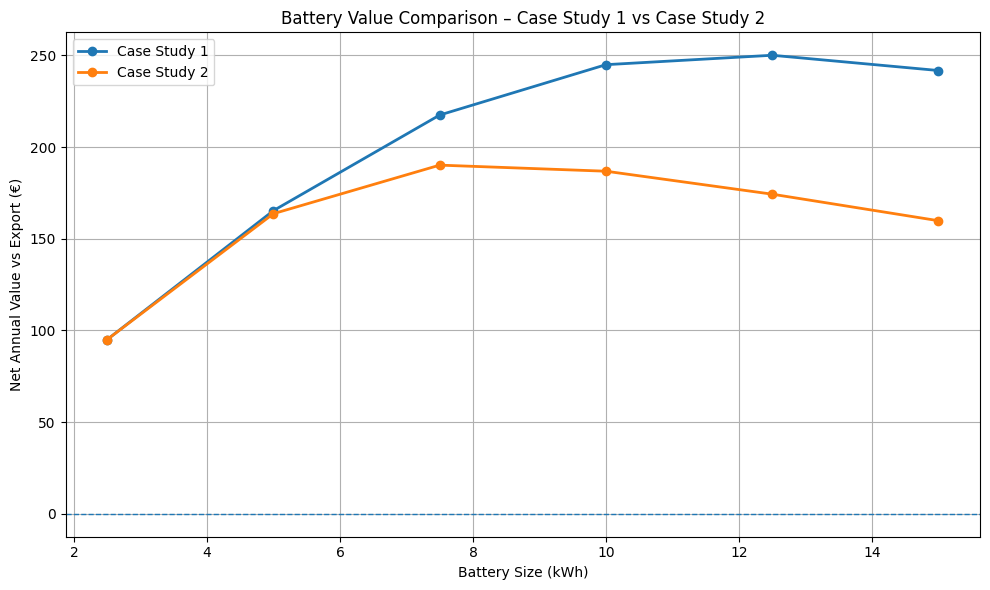

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(
    battery_case1_value['Battery_kWh'],
    battery_case1_value['Net_Value_vs_Export_€'],
    marker='o',
    linewidth=2,
    label='Case Study 1'
)

plt.plot(
    battery_case2_value['Battery_kWh'],
    battery_case2_value['Net_Value_vs_Export_€'],
    marker='o',
    linewidth=2,
    label='Case Study 2'
)

plt.axhline(0, linestyle='--', linewidth=1)

plt.xlabel('Battery Size (kWh)')
plt.ylabel('Net Annual Value vs Export (€)')
plt.title('Battery Value Comparison – Case Study 1 vs Case Study 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Case Study 1 - Capital Expenditure, Degradation and ROI Analysis

In [181]:
# --- CAPEX SETTINGS ---
battery_cost_per_kwh = 300   # € per usable kWh

battery_case1 = battery_case1_value.copy()

# Calculate CAPEX
battery_case1['CAPEX_€'] = (
    battery_case1['Battery_kWh'] * battery_cost_per_kwh
)

battery_case1


,Battery_kWh,Energy_Stored_kWh,Avoided_Import_€,Lost_Export_€,Net_Value_vs_Export_€,CAPEX_€
0,2.5,773.583385,238.175546,143.112926,95.062620,750.0
1,5.0,1368.637215,418.584145,253.197885,165.386260,1500.0
2,7.5,1885.202324,566.283012,348.762430,217.520583,2250.0
3,10.0,2357.349958,681.099645,436.109742,244.989902,3000.0
4,12.5,2758.639094,760.474326,510.348232,250.126094,3750.0
5,15.0,3112.351933,817.586857,575.785108,241.801749,4500.0


In [182]:
# --- DEGRADATION MODEL ---
cycle_life = 8000
round_trip_eff = 0.90

battery_case1['Lifetime_Energy_kWh'] = (
    battery_case1['Battery_kWh'] *
    cycle_life *
    round_trip_eff
)

battery_case1['Degradation_€/yr'] = (
    battery_case1['Energy_Stored_kWh'] /
    battery_case1['Lifetime_Energy_kWh']
) * battery_case1['CAPEX_€']

battery_case1


,Battery_kWh,Energy_Stored_kWh,Avoided_Import_€,Lost_Export_€,Net_Value_vs_Export_€,CAPEX_€,Lifetime_Energy_kWh,Degradation_€/yr
0,2.5,773.583385,238.175546,143.112926,95.062620,750.0,18000.0,32.232641
1,5.0,1368.637215,418.584145,253.197885,165.386260,1500.0,36000.0,57.026551
2,7.5,1885.202324,566.283012,348.762430,217.520583,2250.0,54000.0,78.550097
3,10.0,2357.349958,681.099645,436.109742,244.989902,3000.0,72000.0,98.222915
4,12.5,2758.639094,760.474326,510.348232,250.126094,3750.0,90000.0,114.943296
5,15.0,3112.351933,817.586857,575.785108,241.801749,4500.0,108000.0,129.681331


In [187]:
# ROI (%)
battery_case1['ROI_%'] = (
    battery_case1['Net_Annual_Value_€'] /
    battery_case1['CAPEX_€']
) * 100

# Simple Payback Period (years)
battery_case1['SPB_years'] = (
    battery_case1['CAPEX_€'] /
    battery_case1['Net_Annual_Value_€']
)

battery_case1[['Battery_kWh', 'ROI_%', 'SPB_years']]


,Battery_kWh,ROI_%,SPB_years
0,2.5,8.377331,11.936977
1,5.0,7.223981,13.842784
2,7.5,6.176466,16.190488
3,10.0,4.892233,20.440564
4,12.5,3.604875,27.740216
5,15.0,2.491565,40.135419


#### Case Study 2 - Capital Expenditure, Degradation and ROI Analysis

In [189]:

battery_case2 = battery_case2_value.copy()

battery_case2 = battery_case2.rename(columns={
    'Net_Value_vs_Export_€': 'Net_Annual_Value_€'
})


cost_per_kwh = 1500 / 5   # € per kWh

battery_case2['CAPEX_€'] = battery_case2['Battery_kWh'] * cost_per_kwh


In [190]:
# ROI (%)
battery_case2['ROI_%'] = (
    battery_case2['Net_Annual_Value_€'] /
    battery_case2['CAPEX_€']
) * 100

# Simple Payback Period (years)
battery_case2['SPB_years'] = (
    battery_case2['CAPEX_€'] /
    battery_case2['Net_Annual_Value_€']
)

battery_case2[
    ['Battery_kWh', 'Net_Annual_Value_€', 'CAPEX_€', 'ROI_%', 'SPB_years']
]


,Battery_kWh,Net_Annual_Value_€,CAPEX_€,ROI_%,SPB_years
0,2.5,95.073398,750.0,12.676453,7.888642
1,5.0,163.721257,1500.0,10.914750,9.161914
2,7.5,190.196496,2250.0,8.453178,11.829871
3,10.0,186.873629,3000.0,6.229121,16.053629
4,12.5,174.348477,3750.0,4.649293,21.508648
5,15.0,159.874795,4500.0,3.552773,28.147026


#### ROI Comparsion Between Case Study 1 & 2 

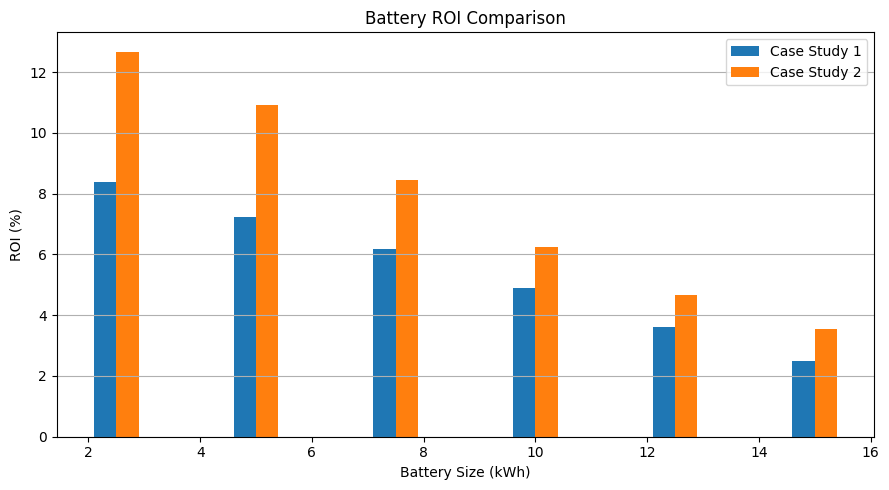

In [191]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

plt.bar(
    battery_case1['Battery_kWh'] - 0.2,
    battery_case1['ROI_%'],
    width=0.4,
    label='Case Study 1'
)

plt.bar(
    battery_case2['Battery_kWh'] + 0.2,
    battery_case2['ROI_%'],
    width=0.4,
    label='Case Study 2'
)

plt.xlabel('Battery Size (kWh)')
plt.ylabel('ROI (%)')
plt.title('Battery ROI Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### SPB Comparison Between Case Study 1 & 2

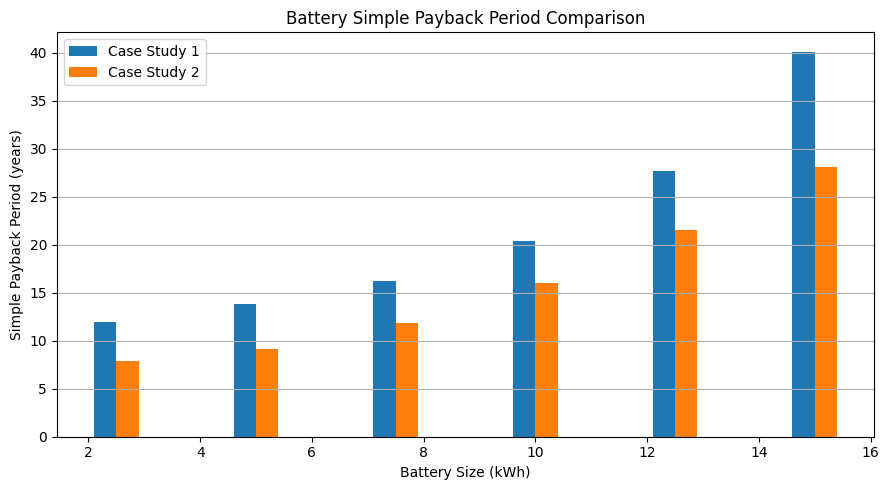

In [192]:
plt.figure(figsize=(9, 5))

plt.bar(
    battery_case1['Battery_kWh'] - 0.2,
    battery_case1['SPB_years'],
    width=0.4,
    label='Case Study 1'
)

plt.bar(
    battery_case2['Battery_kWh'] + 0.2,
    battery_case2['SPB_years'],
    width=0.4,
    label='Case Study 2'
)

plt.xlabel('Battery Size (kWh)')
plt.ylabel('Simple Payback Period (years)')
plt.title('Battery Simple Payback Period Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
